In [461]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import GraphicalLasso
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [462]:
data = pd.read_csv("construct_ggm/pet_graphs/amy_pos_reg_dropleftright.csv",index_col=0)
data.sample(3)

,META_TEMPORAL_VOLUME,INFERIOR_CEREBGM_VOLUME,HEMIWM_VOLUME,BRAIN_STEM_VOLUME,CHOROID_VOLUME,MIDDLEFR_VOLUME,ORBITOFR_VOLUME,PARSFR_VOLUME,CTX_BANKSSTS_VOLUME,CTX_CAUDALANTERIORCINGULATE_VOLUME,...,CTX_SUPERIORTEMPORAL_VOLUME,CTX_SUPRAMARGINAL_VOLUME,CTX_TEMPORALPOLE_VOLUME,CTX_TRANSVERSETEMPORAL_VOLUME,ACCUMBENS_AREA_VOLUME,AMYGDALA_VOLUME,CAUDATE_VOLUME,PALLIDUM_VOLUME,PUTAMEN_VOLUME,THALAMUS_PROPER_VOLUME
563,55950.0,62707.0,298741.0,19178.0,1798.0,33875.0,21615.0,15743.0,3509.0,3194.0,...,19641.0,15595.0,4912.0,1674.0,712.0,2740.0,7138.0,3515.0,7871.0,12574.0
263,59489.0,72736.0,382859.0,18542.0,1416.0,39178.0,27896.0,21774.0,3779.0,3626.0,...,20362.0,21926.0,4348.0,2458.0,987.0,2254.0,6634.0,3413.0,9449.0,12326.0
214,62320.0,72014.0,375631.0,17577.0,1631.0,32616.0,24951.0,17121.0,3525.0,3425.0,...,19848.0,17107.0,5716.0,1666.0,830.0,2954.0,6585.0,3766.0,9295.0,11335.0


In [463]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')

data_scaled = scaler.fit_transform(data)

In [464]:
model = GraphicalLasso(alpha=0.6, 
                       max_iter=100, 
                       tol=1e-2, 
                       mode='cd',
                       assume_centered=True)

model.fit(data_scaled)

GraphicalLasso(alpha=0.6, assume_centered=True, tol=0.01)

In [465]:
alphas = np.linspace(0.015,1.,64)
precision_sparsities = []
covariance_sparsities = []

for alpha in tqdm(alphas): 
    
    model = GraphicalLasso(alpha=alpha, max_iter=1000, tol=1e-2, mode='cd', eps=1e-12, assume_centered=True)
    model.fit(data_scaled)

    precision_sparsities.append(np.count_nonzero(model.precision_)/(model.precision_.size))
    covariance_sparsities.append(np.count_nonzero(model.covariance_)/(model.covariance_.size))

  0%|          | 0/64 [00:00<?, ?it/s]/home/ksrnk/opt/mambaforge/envs/brain-graph/lib/python3.12/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.533e-02
  warnings.warn(
100%|██████████| 64/64 [00:03<00:00, 16.01it/s]


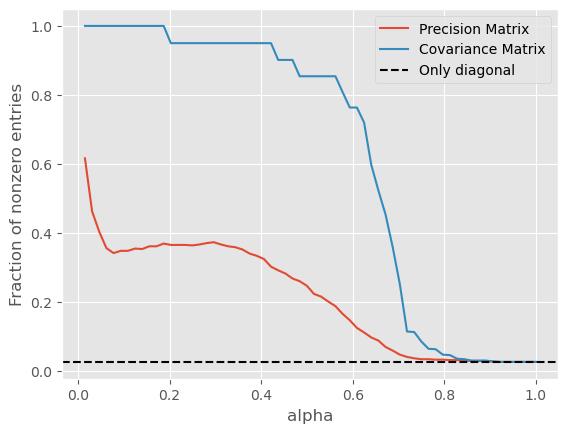

In [466]:
plt.plot(alphas,precision_sparsities,label="Precision Matrix")
plt.plot(alphas,covariance_sparsities,label="Covariance Matrix")
plt.xlabel("alpha")
plt.ylabel("Fraction of nonzero entries")
plt.axhline(1/model.covariance_.shape[0],color='k',linestyle='--',label="Only diagonal")
plt.legend();

# Make graphs

In [487]:
model = GraphicalLasso(alpha=0.7, max_iter=1000, tol=1e-2, mode='cd', eps=1e-12, assume_centered=True)
model.fit(data_scaled)

GraphicalLasso(alpha=0.7, assume_centered=True, eps=1e-12, max_iter=1000,
               tol=0.01)

Text(0.5, 1.0, 'Covariance')

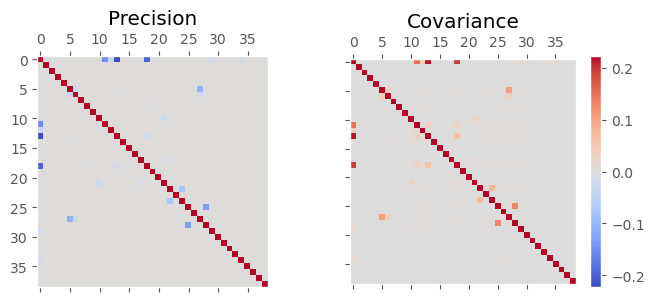

In [488]:
fig,axs = plt.subplots(1,2,figsize=(8,3),sharey=True)

im = axs[0].matshow(model.precision_,cmap='coolwarm',vmin=model.precision_.min(),vmax=-model.precision_.min())
axs[0].grid()
# plt.colorbar(im,ax=axs[0])
axs[0].set_title("Precision")
# axs[0].axis('off')

im = axs[1].matshow(model.covariance_,cmap='coolwarm',vmin=model.precision_.min(),vmax=-model.precision_.min())
axs[1].grid()
plt.colorbar(im,ax=axs[1])
axs[1].set_title("Covariance")
# axs[1].axis('off')

In [489]:
adj = np.copy(model.precision_)

np.fill_diagonal(adj, 0) # remove self connections 

G = nx.Graph(adj)

node_labels = {i: label.rsplit('_',1)[0] for i, label in enumerate(data_scaled.columns)}

G = nx.relabel_nodes(G, node_labels)


In [490]:
G.degree

DegreeView({'META_TEMPORAL': 7, 'INFERIOR_CEREBGM': 0, 'HEMIWM': 0, 'BRAIN_STEM': 0, 'CHOROID': 0, 'MIDDLEFR': 3, 'ORBITOFR': 3, 'PARSFR': 0, 'CTX_BANKSSTS': 1, 'CTX_CAUDALANTERIORCINGULATE': 0, 'CTX_CUNEUS': 1, 'CTX_FUSIFORM': 1, 'CTX_INFERIORPARIETAL': 1, 'CTX_INFERIORTEMPORAL': 2, 'CTX_INSULA': 1, 'CTX_ISTHMUSCINGULATE': 0, 'CTX_LATERALOCCIPITAL': 0, 'CTX_LINGUAL': 1, 'CTX_MIDDLETEMPORAL': 3, 'CTX_PARACENTRAL': 0, 'CTX_PARAHIPPOCAMPAL': 0, 'CTX_PERICALCARINE': 2, 'CTX_POSTCENTRAL': 1, 'CTX_POSTERIORCINGULATE': 0, 'CTX_PRECENTRAL': 1, 'CTX_PRECUNEUS': 1, 'CTX_ROSTRALANTERIORCINGULATE': 0, 'CTX_SUPERIORFRONTAL': 2, 'CTX_SUPERIORPARIETAL': 1, 'CTX_SUPERIORTEMPORAL': 1, 'CTX_SUPRAMARGINAL': 0, 'CTX_TEMPORALPOLE': 0, 'CTX_TRANSVERSETEMPORAL': 0, 'ACCUMBENS_AREA': 0, 'AMYGDALA': 1, 'CAUDATE': 0, 'PALLIDUM': 0, 'PUTAMEN': 0, 'THALAMUS_PROPER': 0})

In [491]:
# Create a colormap for node colors based on node degrees
# node_colors = list(node_degrees.values())

Identify and drop the nodes with no connections

In [492]:
isolates = list(nx.isolates(G))
isolates

['INFERIOR_CEREBGM',
 'HEMIWM',
 'BRAIN_STEM',
 'CHOROID',
 'PARSFR',
 'CTX_CAUDALANTERIORCINGULATE',
 'CTX_ISTHMUSCINGULATE',
 'CTX_LATERALOCCIPITAL',
 'CTX_PARACENTRAL',
 'CTX_PARAHIPPOCAMPAL',
 'CTX_POSTERIORCINGULATE',
 'CTX_ROSTRALANTERIORCINGULATE',
 'CTX_SUPRAMARGINAL',
 'CTX_TEMPORALPOLE',
 'CTX_TRANSVERSETEMPORAL',
 'ACCUMBENS_AREA',
 'CAUDATE',
 'PALLIDUM',
 'PUTAMEN',
 'THALAMUS_PROPER']

In [493]:
G.remove_nodes_from(isolates)

In [494]:
connected_components = list(nx.connected_components(G))
len(connected_components)

4

/tmp/ipykernel_26337/2838395939.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


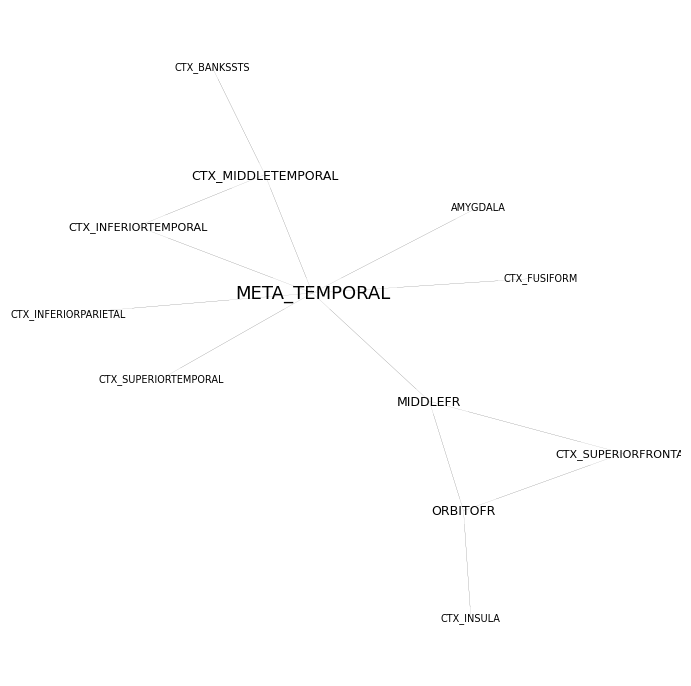

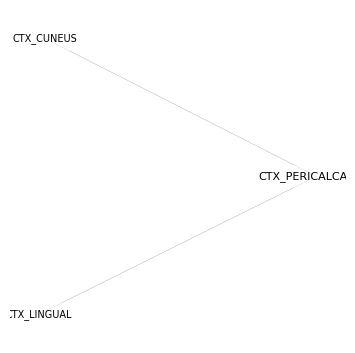

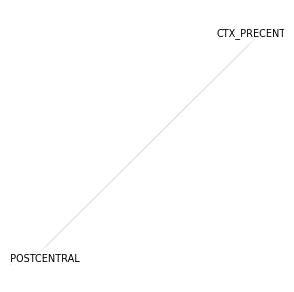

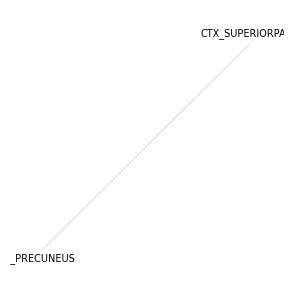

In [495]:
#  Draw the graph with node sizes and colors

for component in connected_components:

    g = G.subgraph(component)

    node_degrees = dict(g.degree())
    node_sizes = [64 * node_degrees[node] for node in g.nodes()]

    L = np.sqrt(len(component))*2.5

    fig,ax = plt.subplots(1,1,figsize=(L,L))
    pos = nx.circular_layout(g)
    pos = nx.kamada_kawai_layout(g,pos=pos,weight=None)
    # pos = nx.spring_layout(g,k=.6,pos=pos,weight=None)

    for node in component:
        nx.draw_networkx_labels(
            G.subgraph(node),
            pos={node:pos[node]},
            font_size=6+G.degree[node],
            bbox={'facecolor':'white','edgecolor':'white','alpha':0.5},
            ax=ax
        )

    nx.draw_networkx_edges(
        g,
        pos,
        width=0.1,
        # style='dashed',
        ax=ax
    )

    ax.axis('off');

# Hubs
Let's take a look at nodes that are highly connected. Do they form triangles?

In [476]:
pos = nx.kamada_kawai_layout(G["META_TEMPORAL"])

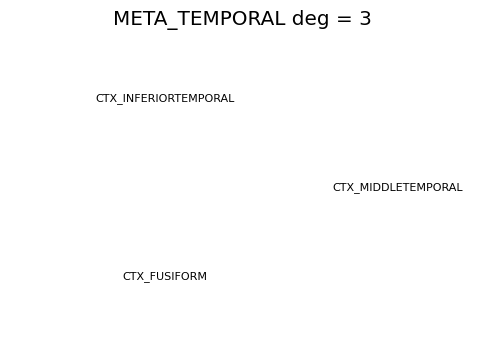

In [477]:
for node, degree in G.degree:
    
    if degree > 1:

        fig,ax = plt.subplots(1,1,figsize=(6,4))

        g = G.subgraph(G.neighbors(node))

        pos = nx.circular_layout(g)
        # pos = nx.kamada_kawai_layout(g,pos,weight=None)

        for n in g:
            nx.draw_networkx_labels(
                G.subgraph(n),
                pos={n:pos[n]},
                # font_size=6+G.degree[n],
                font_size=8,
                bbox={'facecolor':'white','edgecolor':'white','alpha':0.5},
                # ax=ax
            )

        nx.draw_networkx_edges(
            g,
            pos,
            width=.2,
            # style='dashed',
            # ax=ax
        )

        ax.set_xlim(left=-1.5,right=1.5)
        ax.set_ylim(bottom=-1.5,top=1.5)
        
        ax.set_title(node+" deg = "+str(degree))
        ax.axis('off')